In [1]:
import torch
from datasets import *
import visualizer
import models
import matplotlib.pyplot as plt


In [2]:
M_model_state_dict = torch.load(
    'noise_models/spiral_M-DYR-H/0.0/best.pth')
LRM_model_state_dict = torch.load(
    'noise_models/spiral_LRM-DYR-H/0.0/best.pth')


In [3]:
M_model = models.SpiralModel()
M_model.load_state_dict(M_model_state_dict)
LRM_model = models.SpiralModel()
LRM_model.load_state_dict(LRM_model_state_dict)


<All keys matched successfully>

In [4]:
trainset, _, testset = get_spiral_datasets("datasets")

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=len(trainset), shuffle=True, num_workers=1, pin_memory=True)

x_train, y_train = next(iter(train_loader))


/home/masonwang/anaconda3/envs/lnoise-analysis/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


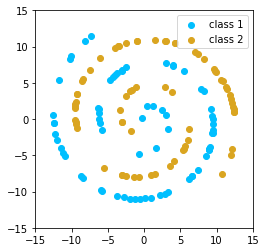

0.5


In [5]:
visualizer.plot_spiral_dataset(x_train, y_train)
print(list(y_train).count(0) / len(y_train))

In [6]:
xi = np.arange(-15, 15, 0.1)
xj = np.arange(-15, 15, 0.1)
x_sample = np.array([[j, i] for i in xi for j in xj])
out = M_model(torch.tensor(x_sample))
out.shape

torch.Size([90000, 2])

/home/masonwang/latent-mixup-LNL-analysis/visualizer.py:79: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x, y, confidence)


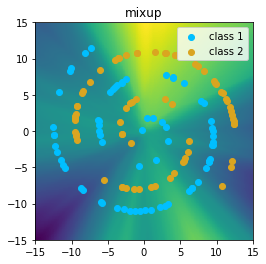

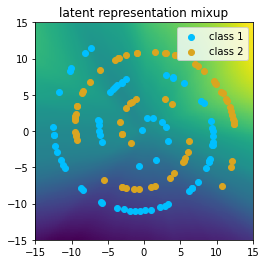

In [7]:
plt.figure(1)
visualizer.plot_spiral_model_confidence(M_model, x_train, y_train, 'mixup')
plt.figure(2)
visualizer.plot_spiral_model_confidence(LRM_model, x_train, y_train, 'latent representation mixup')